### Construa um modelo QSAR em 8 linhas de Python

**Traduzido do Notebook "QSAR in 8 lines" por Patrick Walters. [Link](https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/ml_models/QSAR_in_8_lines.ipynb)**

**Minhas observações são marcadas com a sigla NT**

Quando encontro um novo conjunto de dados, muitas vezes, desejo construir um modelo simples para ter uma ideia rápida de como será fácil ou difícil modelar os dados. Ao longo dos anos, montei vários *scripts* para fazer isso. Recentemente, encontrei alguns pacotes em Python que tornam toda essa tarefa muito mais fácil. Uma coisa que eu gosto no fluxo de trabalho abaixo é que ele é flexível. Posso alterar o formato de entrada, os descritores ou o modelo de aprendizado de máquina alterando apenas uma linha de código. Este *script* não substitui a validação rigorosa, mas fornece um ponto de partida rápido e simples.

In [1]:
# NT: Como o Notebook foi apresentado no Colab, é necessário instalar alguns módulos
%%capture
!pip install rdkit pandas datamol molfeat numpy sklearn yellowbrick

In [2]:
# NT: Versões dos módulos usados

# Python
import sys
print('Python: {}'.format(sys.version))
# datamol
import datamol as dm
print('datamol: {}'.format(dm.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# molfeat
import molfeat
print('molfeat: {}'.format(molfeat.__version__))
# numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
# rdkit
import rdkit
print('rdkit: {}'.format(rdkit.__version__))
# sklearn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
# yellowbrick
import yellowbrick
print('yellowbrick: {}'.format(yellowbrick.__version__))

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
datamol: 0.9.8
matplotlib: 3.7.1
molfeat: 0.8.6
numpy: 1.22.4
pandas: 1.5.3
rdkit: 2022.09.5
sklearn: 1.2.2
yellowbrick: 1.5


In [3]:
import pandas as pd
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from yellowbrick.regressor import prediction_error, residuals_plot

**1.** Importar os dados no formato de [Pandas](https://pandas.pydata.org/) Dataframe

**NT**: ele está usando a função `read_csv` do Pandas para ler um arquivo de texto no formato smi. Esse é simplesmente um arquivo de texto parecido com o csv que em geral contém uma coluna com os nomes ou códigos das estruturas químicas e uma coluna com os SMILES das estruturas. No caso, o arquivo Carbonic.smi que ele está importando diretamente do GitHub contém as colunas "SMILES", "Name" (nome) e "pIC50" (atividade).

In [4]:
filename = "https://raw.githubusercontent.com/PatWalters/yamc/main/data/Carbonic.smi"
df = pd.read_csv(filename, sep=" ", names=["SMILES", "Name", "pIC50"])

**2.** Instanciando um "calculador de *fingerprints* moleculares" do módulo [molfeat](https://m2d2.io/blog/posts/introducing-molfeat-a-hub-of-molecular-featurizers/). Este pacote disponibiliza vários tipos de descritores.

**NT**: o texto abaixo, apesar de estar formatado como código Python, não é executável. É apenas uma representação de código Python anteriormente executado, mostrando todas as possibilidades de *fingerprints* que podemos selecionar usando `molfeat`.
```python
>>> from molfeat.calc import FP_FUNCS
>>> FP_FUNCS.keys()
dict_keys(['maccs', 'avalon', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'map4', 'secfp', 'erg', 'estate', 'avalon-count', 'rdkit-count', 'ecfp-count', 'fcfp-count', 'topological-count', 'atompair-count'])
```

In [5]:
# NT: selecionamos o fingerprint ECFP para esse exemplo
calc = FPCalculator("ecfp")

**3.** Instanciando um *transfomer* do `molfeat`. Este objeto recebe uma lista de SMILES como entrada e retorna seus descritores moleculares. É muito flexível e pode ser executado em paralelo. [Veja aqui! (em inglês)](https://molfeat-docs.datamol.io/stable/tutorials/types_of_featurizers.html)

In [6]:
trans = MoleculeTransformer(calc)

**4-5.** Calculando os *fingerprints*. Observe o uso da função do módulo [datamol](https://datamol.io) que silencia as mensagens de log do RDKit. Esta é uma versão mais educada da minha função rd_shut_the_hell_up em [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils).

In [7]:
%%time
with dm.without_rdkit_log():
    df['fp'] = trans.transform(df.SMILES.values)

CPU times: user 118 ms, sys: 5.92 ms, total: 124 ms
Wall time: 125 ms


**6.** Divida os dados em conjuntos de treinamento e teste. Eu gosto de fazer isso com Dataframes. Dessa forma, não preciso lembrar a ordem em que train_X, test_X, train_y e test_y são retornados pela função [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [13]:
train, test = train_test_split(df, random_state=0)

**7.** Instanciando um regressor no estilo sklearn. Nesse caso, usei o [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html), que é a implementação do scikit-learn do algoritmo [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html). Você pode facilmente usar qualquer regressor compatível com scikit-learn como [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) ou [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html). 
```python
from lightgbm import LGBMRegressor
model = LGBMRegressor()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
from xgboost import XGBRegressor
model = XGBRegressor()
```

In [12]:
model = HistGradientBoostingRegressor(random_state=0)

**8.** Use o [YellowBrick](https://www.scikit-yb.org/en/latest/) para treinar o modelo e visualizar seu desempenho. O valor de **Loss** (NT: função de perda, o erro do modelo em relação à predição) reportado no gráfico abaixo é o R-quadrado ([$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)) para o modelo.

**NT**: a função abaixo foi desenvolvida para fazer em uma linha o que normalmente faríamos em várias linhas usando sklearn e matplotlib. A função `prediction_error` usa como entrada, nessa ordem: uma arquitetura de modelo (modelo não treinado); os descritores (X) do conjunto de treinamento; as respostas (y) do conjunto de treinamento; os descritores (X) do conjunto de teste; as respostas (y) do conjunto de teste. A função retorna, então, a figura abaixo contendo um gráfico das predições vs valores reais, o valor de R-quadrado e o quanto a linha de melhor ajuste difere da identidade (quanto mais próximas, melhor a predição do modelo).

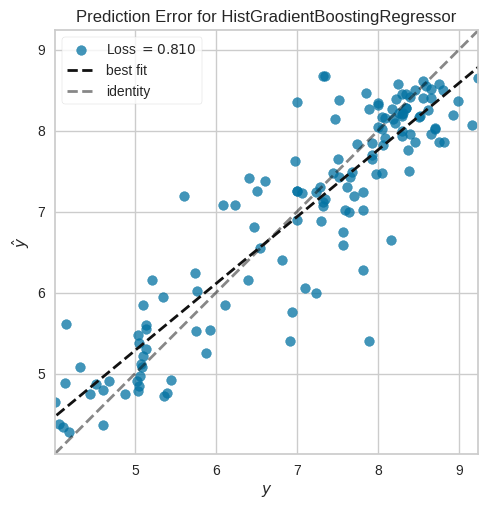

CPU times: user 16.6 s, sys: 1.85 s, total: 18.4 s
Wall time: 11 s


In [14]:
%%time
visualizer = prediction_error(model, np.stack(train.fp), train.pIC50, np.stack(test.fp), test.pIC50)

### Bônus
Plote os resíduos para os conjuntos de treinamento e teste

**NT**: a função `residuals_plot` é similar à usada anteriormente, mas usa o modelo já treinado (o que declaramos com a palavra-chave `is_fitted=True`). Veja, também, que a função `prediction_error` treina o modelo declarado em `model` e que ele permanece treinado para uso em outras funções.

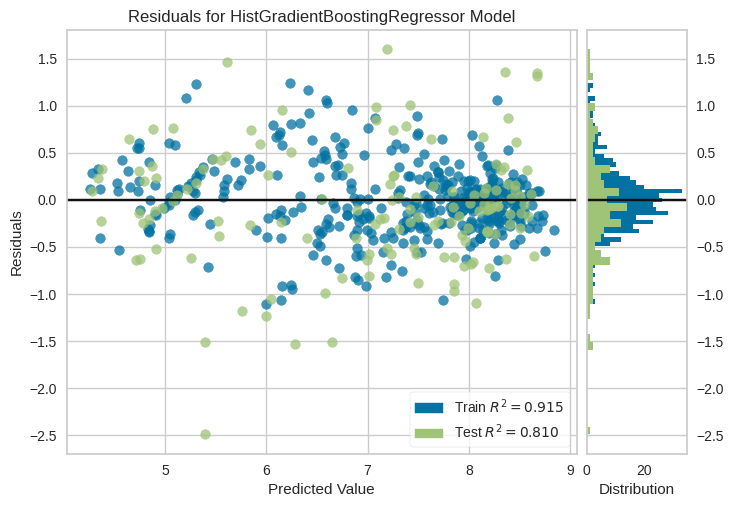

In [15]:
viz = residuals_plot(model, np.stack(train.fp), train.pIC50, np.stack(test.fp), test.pIC50, is_fitted=True)